# Get Data

In [1]:
! python --version

Python 3.7.13


In [2]:
import torch

print(torch.__version__)

1.11.0+cu113


In [1]:
! unrar x -y /content/drive/MyDrive/dataset.rar .
# ZL9195disyolo
# 00202

Streaming output truncated to the last 5000 lines.
dataset/images/001223.jpg - use current password ?
Extracting  ./dataset/images/001223.jpg                                   29%  OK 
dataset/images/001224.jpg - use current password ?
Extracting  ./dataset/images/001224.jpg                                   29%  OK 
dataset/images/001225.jpg - use current password ?
Extracting  ./dataset/images/001225.jpg                                   29%  OK 
dataset/images/001229.jpg - use current password ?
Extracting  ./dataset/images/001229.jpg                                   29%  OK 
dataset/images/00123.jpg - use current password ?
Extracting  ./dataset/images/00123.jpg                                    30%  OK 
dataset/images/001230.jpg - use current password ?
Extracting  ./dataset/images/001230.jpg                                   30%  OK 
dataset/images/001231.jpg - use current password ?
Extracting  ./dataset/images/001231.jpg  

In [2]:
! rm /content/dataset/images/00202.jpg
! rm /content/dataset/masks/00202rebar.jpg
! rm /content/dataset/images/33-5.jpg


In [ ]:
! rm -r /content/train
! rm -r /content/val

! rm -r /content/panopticapi/train
! rm -r /content/panopticapi/val

! rm /content/panoptic_valcoco.json
! rm -r /content/panoptic_valcoco
! rm /content/panoptic_valcoco.json
! rm /content/panopticapi/valcoco.json

! rm /content/valcoco.json
! rm /content/traincoco.json

! rm -r /content/panoptic_traincoco
! rm /content/panoptic_traincoco.json
! rm /content/panopticapi/traincoco.json

# Import Libraries

In [3]:
! pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-she5tfyw
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-she5tfyw
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=584c1297155ba9c1789c35691cfb3fdb52434f9408121313dadb20896cffb691
  Stored in directory: /tmp/pip-ephem-wheel-cache-5ey2bdg0/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


In [ ]:
! pip uninstall pycocotools
! git clone https://github.com/cocodataset/cocoapi.git
% cd /content/cocoapi/PythonAPI


### add function
# PythonAPI/pycocotools/_mask.pyx
! make install


'''def decompress(rleObjs):
    cdef RLEs Rs = _frString(rleObjs)
    rles, hs, ws = [], [], []
    for i in range(Rs.n):
        rles.append([Rs._R[i].cnts[j] for j in range(Rs._R[i].m)])
        hs.append(Rs._R[i].h)
        ws.append(Rs._R[i].w)
    return rles, hs, ws'''

% cd /content

In [4]:

from torchvision.ops import masks_to_boxes
from torchvision.io import read_image
import torch
from PIL import Image, ImageDraw, ImageFont
import cv2
import os

from pycocotools.coco import COCO
from pycocotools import mask as mask_util
from pycocotools import _mask as _mask_util

from panopticapi import utils

import skimage.io as io
import matplotlib.pyplot as plt
import pylab
import scipy


import shutil
from sklearn.model_selection import train_test_split


import glob2
import pandas as pd
import numpy as np
import json
import pandas as pd


import seaborn as sns
pylab.rcParams['figure.figsize'] = (8.0, 10.0)

# Preprocessing

In [5]:
mask_path = '/content/dataset/masks/'

def check_exists(file_id):
  avail_labels = []

  for lab in labs:
    file_name = f"{file_id}{lab}.jpg"
    
    if os.path.exists(f"{mask_path}{file_name}"):
      avail_labels.append(lab)

  return(avail_labels)

In [6]:
fileids, fnames = [], []
labs = ['rebar', 'spall', 'crack']
image_files = glob2.glob('/content/dataset/images/*.jpg')

for f in image_files:

  filename = f.split('/')[-1]
  fileid = filename.split('.')[0]

  fnames.append(filename)
  fileids.append(fileid)

In [ ]:
################### Masking & boxing ###################

In [7]:
### segments intersection


def boundary_iou(gt, dt, dilation_ratio=0.02):
    """
    Compute boundary iou between two binary masks.
    :param gt (numpy array, uint8): binary mask
    :param dt (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary iou (float)
    """
    gt_boundary = mask_to_boundary(gt, dilation_ratio)
    dt_boundary = mask_to_boundary(dt, dilation_ratio)
    intersection = ((gt_boundary * dt_boundary) > 0).sum()
    union = ((gt_boundary + dt_boundary) > 0).sum()
    boundary_iou = intersection / union
    return boundary_iou


def mask_to_boundary(mask, dilation_ratio=0.02):
    """
    Convert binary mask to boundary mask.
    :param mask (numpy array, uint8): binary mask
    :param dilation_ratio (float): ratio to calculate dilation = dilation_ratio * image_diagonal
    :return: boundary mask (numpy array)
    """
    h, w = mask.shape
    img_diag = np.sqrt(h ** 2 + w ** 2)
    dilation = int(round(dilation_ratio * img_diag))
    if dilation < 1:
        dilation = 1
    # Pad image so mask truncated by the image border is also considered as boundary.
    new_mask = cv2.copyMakeBorder(mask, 1, 1, 1, 1, cv2.BORDER_CONSTANT, value=0)
    kernel = np.ones((3, 3), dtype=np.uint8)
    new_mask_erode = cv2.erode(new_mask, kernel, iterations=dilation)
    mask_erode = new_mask_erode[1 : h + 1, 1 : w + 1]
    # G_d intersects G in the paper.
    return mask - mask_erode

In [8]:
images_path = '/content/dataset/images/'
tags = ['labels', 'heights', 'widths', 'bboxes', 
        'segmentations', 'fileids_', 'fnames_']

output_dict = {k: [] for k in tags}

for i in range(len(fileids)):

    fileid = fileids[i]
    fname = fnames[i]

    #print('"""""""""""""""""""""""""""""""""""""""""""')
    #print(f"ID & Name are {fileid} & {fname}")

    image = cv2.imread(images_path+fname)
    height, width, _ = image.shape
    empty_mask = np.zeros((height, width))

    #print(f"Height & Width are {height} & {width}")

    # eg [spall, rebar, etc...]
    labels_check = check_exists(fileid)

    #print(f"Output of Label Check. Length {len(labels_check)} & {labels_check}")

    # No mask found
    if len(labels_check) == 0:
      #print("No Mask Detected ")
      continue
    
    # idx, spall
    for lab_idx, each_label in enumerate(labels_check):

      #print(f"Lab Index & Label {lab_idx} & {each_label}")
      image_path = f"{mask_path}{fileid}{each_label}.jpg"
      src = cv2.imread(image_path, 0)
      ret, thresh = cv2.threshold(src, 127, 255, cv2.THRESH_BINARY)

      num_labels, con_labels = cv2.connectedComponents(thresh)


      #print(f"Connected Comp {num_labels}")
      for num_label_idx in range(1, num_labels):

        label_mask = con_labels == num_label_idx
        label_mask = label_mask.astype(np.uint8)
        empty_mask += label_mask

        encoded = Image.fromarray(label_mask)
        encoded = np.asfortranarray(encoded)
        encoded = mask_util.encode(encoded)

        encoded['counts'] = encoded['counts'].decode('utf-8')

        bbox = mask_util.toBbox(encoded).tolist()

        output_dict['labels'].append(each_label)
        output_dict['bboxes'].append(bbox)
        output_dict['segmentations'].append(encoded)
        output_dict['widths'].append(width)
        output_dict['heights'].append(height)

        output_dict['fileids_'].append(fileid)
        output_dict['fnames_'].append(fname)

    # Repeated --- Fix this
    image_bg = np.invert(empty_mask.astype(np.uint8)) / 255
    encoded = np.asfortranarray(image_bg.astype(np.uint8))
    encoded = mask_util.encode(encoded)
    encoded['counts'] = encoded['counts'].decode('utf-8')
    bbox = [0, 0, width, height]

    output_dict['bboxes'].append(bbox)
    output_dict['segmentations'].append(encoded)
    output_dict['widths'].append(width)
    output_dict['heights'].append(height)

    output_dict['fileids_'].append(fileid)
    output_dict['fnames_'].append(fname)
    output_dict['labels'].append('None')

    assert(boundary_iou(empty_mask.astype('float32'), image_bg.astype('float32')) == 0, "Overlap Detected")
    #print('"""""""""""""""""""""""""""""""""""""""""""')

<ipython-input-8-b0f7abd6dfb0>:82: SyntaxWarning: assertion is always true, perhaps remove parentheses?
  assert(boundary_iou(empty_mask.astype('float32'), image_bg.astype('float32')) == 0, "Overlap Detected")


In [ ]:
src = cv2.imread(f"/content/dataset/masks/{anno_files[60]}", 0)
ret, thresh = cv2.threshold(src, 127, 255, 0)
num_labels, labels = cv2.connectedComponents(thresh)

empty_mask = np.zeros((thresh.shape[0], thresh.shape[1], 3))
empty_mask = empty_mask.astype(np.uint8)


label_mask = labels == 1
label_mask = label_mask.astype(np.uint8)

contours, _ = cv2.findContours(label_mask, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
empty_mask = cv2.drawContours(empty_mask, contours, -1, (255, 255, 0), cv2.FILLED)



In [ ]:
! rm -r /content/train
! rm -r /content/val
! rm /content/valcoco.json
! rm /content/traincoco.json

In [ ]:
problem_ids = []

for i in range(len(fileids)):
    image = "/content/dataset/masks/" + anno_files[i]

    
    src = cv2.imread(image, 0)
    ret, thresh = cv2.threshold(src, 127, 255, 0)

    num_labels, con_labels = cv2.connectedComponents(thresh)
    mask_index = list(np.arange(num_labels))

    comb_idx = list(itertools.combinations(mask_index, 2))

    for idx in comb_idx:
      im1 = con_labels == idx[0]
      im2 = con_labels == idx[1]
      iou = boundary_iou(im1.astype('float32'), im2.astype('float32'))

      if iou > 0:
        problem_ids.append(fileids)

In [ ]:
masks = []
    
image = "/content/dataset/masks/" + '00044rebar.jpg'


src = cv2.imread(image, 0)
ret, thresh = cv2.threshold(src, 127, 255, cv2.THRESH_BINARY)

num_labels, con_labels = cv2.connectedComponents(thresh)

overlaps_map = np.zeros((src.shape), dtype=np.uint32)

for c in range(num_labels):
  im = con_labels == c

  encoded = mask_util.encode(np.asfortranarray(im))
  mask = mask_util.decode(encoded)
  masks.append(mask)

  overlaps_map += mask

print(num_labels)

image = "/content/dataset/masks/" + '00044spall.jpg'

src = cv2.imread(image, 0)
ret, thresh = cv2.threshold(src, 127, 255, cv2.THRESH_BINARY)

num_labels, con_labels = cv2.connectedComponents(thresh)



for c in range(num_labels):
  im = con_labels == c

  encoded = mask_util.encode(np.asfortranarray(im))
  mask = mask_util.decode(encoded)
  masks.append(mask)

  overlaps_map += mask


print(num_labels)

if np.sum(overlaps_map > 1) != 0:
    raise Exception("Segments for image overlap each other.")

In [ ]:
########################################################

In [9]:
capstone_df = pd.DataFrame({
    "fileid": output_dict['fileids_'],
    "filename": output_dict['fnames_'],
    "height": output_dict['heights'],
    "width": output_dict['widths'],
    "bboxes": output_dict['bboxes'],
    "segmentations": output_dict['segmentations'],
    "class": output_dict['labels']
})
capstone_df.head()

,fileid,filename,height,width,bboxes,segmentations,class
0,001163,001163.jpg,754,1008,"[437.0, 175.0, 311.0, 226.0]","{'size': [754, 1008], 'counts': 'iQR:?of06L4M3...",spall
1,001163,001163.jpg,754,1008,"[0, 0, 1008, 754]","{'size': [754, 1008], 'counts': '0iQR:?VenE6L4...",None
2,000531,000531.jpg,754,1008,"[545.0, 0.0, 197.0, 754.0]","{'size': [754, 1008], 'counts': 'eYa<4[g06M3^Y...",crack
3,000531,000531.jpg,754,1008,"[0, 0, 1008, 754]","{'size': [754, 1008], 'counts': '0eYa<4f]_C6M3...",None
4,14-4,14-4.jpg,960,1280,"[180.0, 302.0, 252.0, 104.0]","{'size': [960, 1280], 'counts': ']SY53lm03L3N1...",rebar


In [10]:
capstone_df[['xmin', 'ymin', 'xmax','ymax']] = pd.DataFrame(capstone_df.bboxes.tolist(), index= capstone_df.index)
capstone_df = capstone_df.drop(['bboxes', 'fileid'], axis=1)
capstone_df.rename(columns = {'value_y':'segmentation'}, inplace = True)
capstone_df


,filename,height,width,segmentations,class,xmin,ymin,xmax,ymax
0,001163.jpg,754,1008,"{'size': [754, 1008], 'counts': 'iQR:?of06L4M3...",spall,437.0,175.0,311.0,226.0
1,001163.jpg,754,1008,"{'size': [754, 1008], 'counts': '0iQR:?VenE6L4...",None,0.0,0.0,1008.0,754.0
2,000531.jpg,754,1008,"{'size': [754, 1008], 'counts': 'eYa<4[g06M3^Y...",crack,545.0,0.0,197.0,754.0
3,000531.jpg,754,1008,"{'size': [754, 1008], 'counts': '0eYa<4f]_C6M3...",None,0.0,0.0,1008.0,754.0
4,14-4.jpg,960,1280,"{'size': [960, 1280], 'counts': ']SY53lm03L3N1...",rebar,180.0,302.0,252.0,104.0
...,...,...,...,...,...,...,...,...,...
3504,000936.jpg,754,1008,"{'size': [754, 1008], 'counts': 'jmT42`g01O1O0...",spall,180.0,297.0,335.0,176.0
3505,000936.jpg,754,1008,"{'size': [754, 1008], 'counts': '0jmT42fikK1O1...",None,0.0,0.0,1008.0,754.0
3506,1074-13.jpg,480,640,"{'size': [480, 640], 'counts': 'SYW37g>4M3M2N3...",rebar,220.0,157.0,56.0,52.0
3507,1074-13.jpg,480,640,"{'size': [480, 640], 'counts': 'hbX54k>2N2N2N2...",rebar,359.0,303.0,27.0,22.0


In [14]:
### test viz
val_files = [x.split('/')[-1] for x in glob2.glob('/content/val/*.jpg')]
val_merged = capstone_df[capstone_df.filename.isin(val_files)][['filename', 'class', "xmin",	"ymin",	"xmax",	"ymax"]]
val_ind = val_merged['filename'].value_counts().index

In [15]:
val_library = {}

def build_groundval(val_library):

  for ind in val_ind:

    val_merged_subset = val_merged[val_merged.filename == ind]

    labels = val_merged_subset['class'].tolist()
    boxes = val_merged_subset.apply(lambda x: [x['xmin'], x['ymin'], 
                                              x['xmax'], x['ymax']], axis=1).tolist()

    if ind in val_library.keys():
      val_library[ind]["ground_truth"]["boxes"].extend(boxes)
      val_library[ind]["ground_truth"]["labels"].extend(labels)

    else:
      val_library[ind] = {"ground_truth": {"boxes": [], "labels": []}}

      val_library[ind]["ground_truth"]["boxes"].extend(boxes)
      val_library[ind]["ground_truth"]["labels"].extend(labels)

  return(val_library)


val_library = build_groundval(val_library)

In [16]:
val_library.keys()

dict_keys(['0036301.jpg', '0037301.jpg', '0033601.jpg', '1055-9.jpg', '0036303.jpg', '00058.jpg', '00366.jpg', '00036.jpg', '172-3.jpg', '000753.jpg', '001324.jpg', '35-6.jpg', '979-5.jpg', '0032801.jpg', '1074-14.jpg', 'IMG_544600.jpg', '764-3.jpg', '00318.jpg', '0030502.jpg', '000626.jpg', '001012.jpg', '1069-8.jpg', '001222.jpg', 'IMG_530405.jpg', '00082.jpg', '00374.jpg', 'IMG_535906.jpg', '0032901.jpg', '844-12.jpg', '000653.jpg', '1049-16.jpg', '000522.jpg', '000742.jpg', '0074.jpg', 'IMG_535805.jpg', 'IMG_7303.jpg', '0034701.jpg', '974-4.jpg', '0032601.jpg', '001307.jpg', '985-4.jpg', '31-1.jpg', '000648.jpg', '000107.jpg', '001309.jpg', '1048-4.jpg', '170-2.jpg', '01028.jpg', '00341.jpg', '000916.jpg', 'IMG_900500.jpg', 'IMG_899203.jpg', '0023.jpg', '001016.jpg', '0616.jpg', '0035402.jpg', '171-700.jpg', '10-1.jpg', '1068-9.jpg', '0246.jpg', '000125.jpg', '5-303.jpg', '844-7.jpg', '0035902.jpg', '0110.jpg', '001292.jpg', '832-7.jpg', 'IMG_800605.jpg', '00275.jpg', '172-13.jpg',

In [17]:
for ind in val_ind:

  fileinfo = val_library[ind]['ground_truth']


  path = f"val/{ind}"
  im = Image.open(path).convert('RGB')

  draw = ImageDraw.Draw(im)
  font = ImageFont.load_default()

  labels = ['None', 'rebar', 'spall', 'crack']
  colors = ['blue', 'red', 'black', 'white']

  idx2label = {v: k for v, k in enumerate(labels)}
  label2idx = {k: v for v, k in enumerate(labels)}

  for i, box in enumerate(fileinfo['boxes']):
    label = fileinfo['labels'][i]
    if label == "None":
      continue
    draw.rectangle([box[0], box[1], box[0]+box[2], box[1]+box[3]], outline=colors[label2idx[label]], width=3)
    draw.text((box[0] + 20, box[1] + 20), label, 
                font=font, fill=colors[label2idx[label]])
    
    im.save(f"groundviz/{ind}")

In [29]:
lab_colors = {
    'spall': [220, 20, 60], 
    'None': [119, 11, 32], 
    'crack': [73, 77, 174], 
    'rebar': [107, 255, 200]
}

In [11]:
allfiles = capstone_df['filename'].tolist()
allfiles = list(set(allfiles))

split = int(len(allfiles) * 0.8)


train_files, val_files = allfiles[:split], allfiles[split:]

In [12]:
! mkdir train
! mkdir val

for eachimage in train_files:
  shutil.copy(f'/content/dataset/images/{eachimage}', 'train/')

for eachimage in val_files:
  shutil.copy(f'/content/dataset/images/{eachimage}', 'val/')

In [13]:
train_df = capstone_df[capstone_df['filename'].isin(train_files)]
val_df = capstone_df[capstone_df['filename'].isin(val_files)]

In [142]:
% cd /content

/content


# Convert to COCO

In [ ]:
def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid
    category["name"] = row['class']
    category["isthing"] = 1 if row['class'] in labs else 0
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)
    annotation["segmentation"] = [row.segmentation]
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    #annotation["bbox"] = [row.xmin, row.ymin, row.xmax -row.xmin,row.ymax-row.ymin]
    annotation["bbox"] = [row.xmin, row.ymin, row.xmax, row.ymax]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

def make_coco(save_json_path, data):
  images = []
  categories = []
  annotations = []

  category = {}
  category["supercategory"] = 'none'
  category["id"] = 0
  category["name"] = 'None'
  category["isthing"] = 0
  #categories.append(category)
  # filename	height	width	class	segmentation	xmin	ymin	xmax	ymax

  data['fileid'] = data['filename'].astype('category').cat.codes
  data['categoryid']= pd.Categorical(data['class'], ordered= True).codes
  data['categoryid'] = data['categoryid']+1
  data['annid'] = data.index


  for row in data.itertuples():
      annotations.append(annotation(row))

  imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
  for row in imagedf.itertuples():
      images.append(image(row))

  catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
  for row in catdf.itertuples():
      categories.append(category(row))

  data_coco = {}
  data_coco["images"] = images
  data_coco["categories"] = categories
  data_coco["annotations"] = annotations
  json.dump(data_coco, open(save_json_path, "w"), indent=4)

In [ ]:
make_coco('train_coco.json', train_df)
make_coco('val_coco.json', val_df)

In [110]:
lab_colors = {
    'spall': [220, 20, 60], 
    'None': [119, 11, 32], 
    'crack': [73, 77, 174], 
    'rebar': [107, 255, 200]
}

In [112]:
save_json_path = 'valcoco.json'


data = val_df

images = []
categories = []
annotations = []

category = {}
category["supercategory"] = 'none'
category["id"] = 0
category["name"] = 'None'
category["isthing"] = 0
#categories.append(category)

data['fileid'] = data['filename'].astype('category').cat.codes
data['categoryid']= pd.Categorical(data['class'], ordered= True).codes
data['categoryid'] = data['categoryid']+1
data['annid'] = data.index

def image(row):
    image = {}
    image["height"] = row.height
    image["width"] = row.width
    image["id"] = row.fileid
    image["file_name"] = row.filename
    return image

def category(row):
    category = {}
    category["supercategory"] = 'None'
    category["id"] = row.categoryid

    category["name"] = row[5]
    category["isthing"] = 1 if row[5] in labs else 0
    category["color"] = lab_colors[row[5]]
    return category

def annotation(row):
    annotation = {}
    area = (row.xmax -row.xmin)*(row.ymax - row.ymin)

    annotation["segmentation"] = row.segmentations
    annotation["iscrowd"] = 0
    annotation["area"] = area
    annotation["image_id"] = row.fileid

    annotation["bbox"] = [row.xmin, row.ymin, row.xmax, row.ymax]

    annotation["category_id"] = row.categoryid
    annotation["id"] = row.annid
    return annotation

for row in data.itertuples():
    annotations.append(annotation(row))

imagedf = data.drop_duplicates(subset=['fileid']).sort_values(by='fileid')
for row in imagedf.itertuples():
    images.append(image(row))

catdf = data.drop_duplicates(subset=['categoryid']).sort_values(by='categoryid')
for row in catdf.itertuples():
    categories.append(category(row))

data_coco = {}
data_coco["images"] = images
data_coco["categories"] = categories
data_coco["annotations"] = annotations
json.dump(data_coco, open(save_json_path, "w"), indent=4)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stab

In [ ]:
# investigate coco
! rm -r /content/train
! rm -r /content/val

! rm -r /content/panopticapi/train
! rm -r /content/panopticapi/val

! rm /content/panopticapi/valcoco.json
! rm /content/panopticapi/traincoco.json


! rm /content/panopticapi/valcoco.json

In [37]:
% cd /content

/content


In [114]:
! ls /content/panoptic_traincoco | wc -l

942


loading annotations into memory...
Done (t=0.24s)
creating index...
index created!


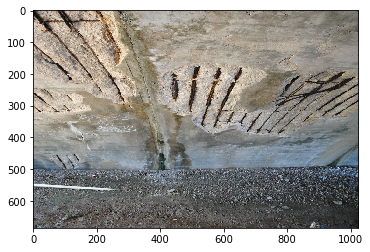

In [32]:
coco = COCO('/content/valcoco.json')
img_dir = '/content/dataset/images'
image_id = 11

img = coco.imgs[image_id]


image = np.array(Image.open(os.path.join(img_dir, img['file_name'])))
plt.imshow(image, interpolation='nearest')
plt.show()

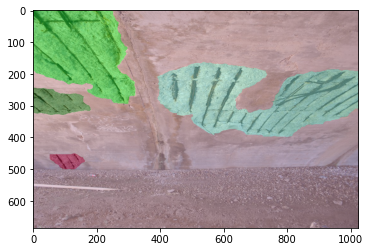

In [33]:
plt.imshow(image)
cat_ids = coco.getCatIds()
anns_ids = coco.getAnnIds(imgIds=img['id'], catIds=cat_ids, iscrowd=None)
anns = coco.loadAnns(anns_ids)
coco.showAnns(anns)
#coco.showAnns(anns, draw_bbox=True)

In [25]:
capstone_df[capstone_df['filename'] == '33-5.jpg']

,filename,height,width,segmentations,class,xmin,ymin,xmax,ymax


In [ ]:
! rm -r /content/DETR

In [ ]:
! pip install -U 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
! git clone https://github.com/cydal/DETR.git

Cloning into 'DETR'...
remote: Enumerating objects: 210, done.
remote: Counting objects: 100% (210/210), done.
remote: Compressing objects: 100% (165/165), done.
remote: Total 210 (delta 73), reused 162 (delta 35), pack-reused 0
Receiving objects: 100% (210/210), 25.14 MiB | 12.18 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [ ]:
! git clone https://github.com/facebookresearch/detr.git

Cloning into 'detr'...
remote: Enumerating objects: 260, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 260 (delta 0), reused 1 (delta 0), pack-reused 257
Receiving objects: 100% (260/260), 12.85 MiB | 23.41 MiB/s, done.
Resolving deltas: 100% (140/140), done.


# Detr Training

In [ ]:
# Get pretrained weights
# https://dl.fbaipublicfiles.com/detr/detr-r101-2c7b67e5.pth
checkpoint = torch.hub.load_state_dict_from_url(
            url='https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth',
            map_location='cpu',
            check_hash=True)

# Remove class weights
del checkpoint["model"]["class_embed.weight"]
del checkpoint["model"]["class_embed.bias"]

# Save
torch.save(checkpoint,
           'detr-r50_no-class-head.pth')

Downloading: "https://dl.fbaipublicfiles.com/detr/detr-r50-e632da11.pth" to /root/.cache/torch/hub/checkpoints/detr-r50-e632da11.pth


  0%|          | 0.00/159M [00:00<?, ?B/s]

In [ ]:
! python /content/detr/main.py --output_dir /content/output --coco_path /content/dataset --resume /content/detr-r50_no-class-head.pth

In [ ]:
# Averaged stats: lr: 0.000100  class_error: 87.50  loss: 27.7239 (33.4584)  loss_ce: 0.8376 (0.8896)  loss_bbox: 1.5726 (2.9218)  loss_giou: 1.4204 (1.6828)  loss_ce_0: 0.9247 (0.8701)  loss_bbox_0: 2.0143 (3.0946)  loss_giou_0: 1.5215 (1.6884)  loss_ce_1: 0.8696 (0.8855)  loss_bbox_1: 1.5695 (2.9634)  loss_giou_1: 1.4630 (1.6916)  loss_ce_2: 0.9155 (0.8966)  loss_bbox_2: 1.6453 (2.9796)  loss_giou_2: 1.3902 (1.6935)  loss_ce_3: 0.8910 (0.8966)  loss_bbox_3: 1.7249 (3.0053)  loss_giou_3: 1.4722 (1.6969)  loss_ce_4: 0.9104 (0.9052)  loss_bbox_4: 1.5810 (3.0160)  loss_giou_4: 1.5160 (1.6808)  loss_ce_unscaled: 0.8376 (0.8896)  class_error_unscaled: 81.8182 (62.2449)  loss_bbox_unscaled: 0.3145 (0.5844)  loss_giou_unscaled: 0.7102 (0.8414)  cardinality_error_unscaled: 4.0000 (9.3219)  loss_ce_0_unscaled: 0.9247 (0.8701)  loss_bbox_0_unscaled: 0.4029 (0.6189)  loss_giou_0_unscaled: 0.7607 (0.8442)  cardinality_error_0_unscaled: 5.0000 (8.7842)  loss_ce_1_unscaled: 0.8696 (0.8855)  loss_bbox_1_unscaled: 0.3139 (0.5927)  loss_giou_1_unscaled: 0.7315 (0.8458)  cardinality_error_1_unscaled: 6.0000 (9.4462)  loss_ce_2_unscaled: 0.9155 (0.8966)  loss_bbox_2_unscaled: 0.3291 (0.5959)  loss_giou_2_unscaled: 0.6951 (0.8468)  cardinality_error_2_unscaled: 5.0000 (10.6138)  loss_ce_3_unscaled: 0.8910 (0.8966)  loss_bbox_3_unscaled: 0.3450 (0.6011)  loss_giou_3_unscaled: 0.7361 (0.8485)  cardinality_error_3_unscaled: 11.5000 (11.4518)  loss_ce_4_unscaled: 0.9104 (0.9052)  loss_bbox_4_unscaled: 0.3162 (0.6032)  loss_giou_4_unscaled: 0.7580 (0.8404)  cardinality_error_4_unscaled: 9.5000 (12.5908)
# Averaged stats: lr: 0.000100  class_error: 25.00  loss: 26.3560 (27.6837)  loss_ce: 1.0150 (0.8818)  loss_bbox: 1.5885 (2.1096)  loss_giou: 1.1568 (1.5625)  loss_ce_0: 0.9546 (0.8604)  loss_bbox_0: 1.7382 (2.2744)  loss_giou_0: 1.0494 (1.5939)  loss_ce_1: 0.9049 (0.8767)  loss_bbox_1: 1.6412 (2.1817)  loss_giou_1: 1.0474 (1.5918)  loss_ce_2: 0.8618 (0.8768)  loss_bbox_2: 1.6310 (2.1509)  loss_giou_2: 1.1072 (1.5758)  loss_ce_3: 0.8524 (0.8825)  loss_bbox_3: 1.3864 (2.1308)  loss_giou_3: 1.1477 (1.5680)  loss_ce_4: 0.9195 (0.8926)  loss_bbox_4: 1.4197 (2.1156)  loss_giou_4: 1.1657 (1.5581)  loss_ce_unscaled: 1.0150 (0.8818)  class_error_unscaled: 47.3684 (62.2064)  loss_bbox_unscaled: 0.3177 (0.4219)  loss_giou_unscaled: 0.5784 (0.7813)  cardinality_error_unscaled: 17.0000 (9.2884)  loss_ce_0_unscaled: 0.9546 (0.8604)  loss_bbox_0_unscaled: 0.3476 (0.4549)  loss_giou_0_unscaled: 0.5247 (0.7969)  cardinality_error_0_unscaled: 14.5000 (10.2703)  loss_ce_1_unscaled: 0.9049 (0.8767)  loss_bbox_1_unscaled: 0.3282 (0.4363)  loss_giou_1_unscaled: 0.5237 (0.7959)  cardinality_error_1_unscaled: 6.5000 (8.1711)  loss_ce_2_unscaled: 0.8618 (0.8768)  loss_bbox_2_unscaled: 0.3262 (0.4302)  loss_giou_2_unscaled: 0.5536 (0.7879)  cardinality_error_2_unscaled: 11.5000 (8.4246)  loss_ce_3_unscaled: 0.8524 (0.8825)  loss_bbox_3_unscaled: 0.2773 (0.4262)  loss_giou_3_unscaled: 0.5739 (0.7840)  cardinality_error_3_unscaled: 11.0000 (9.0042)  loss_ce_4_unscaled: 0.9195 (0.8926)  loss_bbox_4_unscaled: 0.2839 (0.4231)  loss_giou_4_unscaled: 0.5829 (0.7790)  cardinality_error_4_unscaled: 12.5000 (9.8443)
# Averaged stats: lr: 0.000100  class_error: 93.33  loss: 26.0411 (26.2823)  loss_ce: 0.9020 (0.8896)  loss_bbox: 1.4973 (1.9366)  loss_giou: 1.5358 (1.4710)  loss_ce_0: 0.9986 (0.8822)  loss_bbox_0: 1.5839 (2.0600)  loss_giou_0: 1.3702 (1.5202)  loss_ce_1: 0.8751 (0.8849)  loss_bbox_1: 1.6434 (2.0129)  loss_giou_1: 1.5304 (1.5191)  loss_ce_2: 0.9036 (0.8784)  loss_bbox_2: 1.6673 (1.9735)  loss_giou_2: 1.3955 (1.5489)  loss_ce_3: 0.9050 (0.8859)  loss_bbox_3: 1.6445 (1.9741)  loss_giou_3: 1.4531 (1.5390)  loss_ce_4: 0.9033 (0.8973)  loss_bbox_4: 1.5547 (1.9293)  loss_giou_4: 1.4070 (1.4792)  loss_ce_unscaled: 0.9020 (0.8896)  class_error_unscaled: 91.1111 (67.1653)  loss_bbox_unscaled: 0.2995 (0.3873)  loss_giou_unscaled: 0.7679 (0.7355)  cardinality_error_unscaled: 4.0000 (8.5363)  loss_ce_0_unscaled: 0.9986 (0.8822)  loss_bbox_0_unscaled: 0.3168 (0.4120)  loss_giou_0_unscaled: 0.6851 (0.7601)  cardinality_error_0_unscaled: 4.5000 (9.6075)  loss_ce_1_unscaled: 0.8751 (0.8849)  loss_bbox_1_unscaled: 0.3287 (0.4026)  loss_giou_1_unscaled: 0.7652 (0.7596)  cardinality_error_1_unscaled: 5.5000 (7.9113)  loss_ce_2_unscaled: 0.9036 (0.8784)  loss_bbox_2_unscaled: 0.3335 (0.3947)  loss_giou_2_unscaled: 0.6977 (0.7745)  cardinality_error_2_unscaled: 4.5000 (7.8771)  loss_ce_3_unscaled: 0.9050 (0.8859)  loss_bbox_3_unscaled: 0.3289 (0.3948)  loss_giou_3_unscaled: 0.7265 (0.7695)  cardinality_error_3_unscaled: 5.0000 (8.3059)  loss_ce_4_unscaled: 0.9033 (0.8973)  loss_bbox_4_unscaled: 0.3109 (0.3859)  loss_giou_4_unscaled: 0.7035 (0.7396)  cardinality_error_4_unscaled: 4.0000 (9.4043)
# Averaged stats: lr: 0.000100  class_error: 100.00  loss: 21.6928 (25.6137)  loss_ce: 0.8139 (0.8918)  loss_bbox: 1.4627 (1.8488)  loss_giou: 1.3858 (1.4551)  loss_ce_0: 0.7874 (0.8832)  loss_bbox_0: 1.8061 (1.9853)  loss_giou_0: 1.5002 (1.4934)  loss_ce_1: 0.8025 (0.8816)  loss_bbox_1: 1.8208 (1.9645)  loss_giou_1: 1.2999 (1.4955)  loss_ce_2: 0.8103 (0.8869)  loss_bbox_2: 1.6782 (1.8999)  loss_giou_2: 1.3198 (1.5054)  loss_ce_3: 0.7937 (0.8974)  loss_bbox_3: 1.5110 (1.8664)  loss_giou_3: 1.4740 (1.4755)  loss_ce_4: 0.7373 (0.8906)  loss_bbox_4: 1.3971 (1.8467)  loss_giou_4: 1.2319 (1.4457)  loss_ce_unscaled: 0.8139 (0.8918)  class_error_unscaled: 77.7778 (70.6120)  loss_bbox_unscaled: 0.2925 (0.3698)  loss_giou_unscaled: 0.6929 (0.7276)  cardinality_error_unscaled: 4.0000 (7.9686)  loss_ce_0_unscaled: 0.7874 (0.8832)  loss_bbox_0_unscaled: 0.3612 (0.3971)  loss_giou_0_unscaled: 0.7501 (0.7467)  cardinality_error_0_unscaled: 5.5000 (8.5517)  loss_ce_1_unscaled: 0.8025 (0.8816)  loss_bbox_1_unscaled: 0.3642 (0.3929)  loss_giou_1_unscaled: 0.6500 (0.7477)  cardinality_error_1_unscaled: 6.5000 (7.7605)  loss_ce_2_unscaled: 0.8103 (0.8869)  loss_bbox_2_unscaled: 0.3356 (0.3800)  loss_giou_2_unscaled: 0.6599 (0.7527)  cardinality_error_2_unscaled: 6.0000 (7.6613)  loss_ce_3_unscaled: 0.7937 (0.8974)  loss_bbox_3_unscaled: 0.3022 (0.3733)  loss_giou_3_unscaled: 0.7370 (0.7378)  cardinality_error_3_unscaled: 4.0000 (8.5782)  loss_ce_4_unscaled: 0.7373 (0.8906)  loss_bbox_4_unscaled: 0.2794 (0.3693)  loss_giou_4_unscaled: 0.6160 (0.7229)  cardinality_error_4_unscaled: 4.0000 (9.0021)
# Averaged stats: lr: 0.000100  class_error: 91.30  loss: 19.9217 (24.8648)  loss_ce: 0.7225 (0.8953)  loss_bbox: 1.8066 (1.7676)  loss_giou: 1.2776 (1.4242)  loss_ce_0: 0.7416 (0.8906)  loss_bbox_0: 1.5349 (1.8766)  loss_giou_0: 1.0932 (1.4510)  loss_ce_1: 0.7100 (0.8882)  loss_bbox_1: 1.2923 (1.8513)  loss_giou_1: 0.9702 (1.4730)  loss_ce_2: 0.7246 (0.8865)  loss_bbox_2: 1.4818 (1.8445)  loss_giou_2: 1.1519 (1.4750)  loss_ce_3: 0.6669 (0.8896)  loss_bbox_3: 1.7840 (1.7702)  loss_giou_3: 1.0278 (1.4340)  loss_ce_4: 0.6997 (0.8905)  loss_bbox_4: 1.4078 (1.7475)  loss_giou_4: 0.8866 (1.4091)  loss_ce_unscaled: 0.7225 (0.8953)  class_error_unscaled: 88.8889 (72.7268)  loss_bbox_unscaled: 0.3613 (0.3535)  loss_giou_unscaled: 0.6388 (0.7121)  cardinality_error_unscaled: 3.0000 (8.1823)  loss_ce_0_unscaled: 0.7416 (0.8906)  loss_bbox_0_unscaled: 0.3070 (0.3753)  loss_giou_0_unscaled: 0.5466 (0.7255)  cardinality_error_0_unscaled: 7.0000 (8.6927)  loss_ce_1_unscaled: 0.7100 (0.8882)  loss_bbox_1_unscaled: 0.2585 (0.3703)  loss_giou_1_unscaled: 0.4851 (0.7365)  cardinality_error_1_unscaled: 6.0000 (7.8101)  loss_ce_2_unscaled: 0.7246 (0.8865)  loss_bbox_2_unscaled: 0.2964 (0.3689)  loss_giou_2_unscaled: 0.5760 (0.7375)  cardinality_error_2_unscaled: 5.5000 (8.0203)  loss_ce_3_unscaled: 0.6669 (0.8896)  loss_bbox_3_unscaled: 0.3568 (0.3540)  loss_giou_3_unscaled: 0.5139 (0.7170)  cardinality_error_3_unscaled: 4.0000 (7.8080)  loss_ce_4_unscaled: 0.6997 (0.8905)  loss_bbox_4_unscaled: 0.2816 (0.3495)  loss_giou_4_unscaled: 0.4433 (0.7045)  cardinality_error_4_unscaled: 4.0000 (8.1711)


# Averaged stats: class_error: 87.50  loss: 58.7354 (58.1786)  loss_ce: 0.8797 (0.9332)  loss_bbox: 6.0138 (5.9857)  loss_giou: 2.6104 (2.6209)  loss_ce_0: 0.7945 (0.8335)  loss_bbox_0: 6.1132 (6.5317)  loss_giou_0: 2.6452 (2.7016)  loss_ce_1: 0.8341 (0.8836)  loss_bbox_1: 6.1164 (6.2809)  loss_giou_1: 2.5916 (2.6571)  loss_ce_2: 0.8269 (0.8824)  loss_bbox_2: 6.0487 (6.1036)  loss_giou_2: 2.5534 (2.6309)  loss_ce_3: 0.8153 (0.8756)  loss_bbox_3: 5.9479 (5.9877)  loss_giou_3: 2.5288 (2.6134)  loss_ce_4: 0.8286 (0.8780)  loss_bbox_4: 6.1954 (6.1348)  loss_giou_4: 2.6084 (2.6440)  loss_ce_unscaled: 0.8797 (0.9332)  class_error_unscaled: 100.0000 (95.0238)  loss_bbox_unscaled: 1.2028 (1.1971)  loss_giou_unscaled: 1.3052 (1.3105)  cardinality_error_unscaled: 4.0000 (4.9144)  loss_ce_0_unscaled: 0.7945 (0.8335)  loss_bbox_0_unscaled: 1.2226 (1.3063)  loss_giou_0_unscaled: 1.3226 (1.3508)  cardinality_error_0_unscaled: 4.0000 (4.9144)  loss_ce_1_unscaled: 0.8341 (0.8836)  loss_bbox_1_unscaled: 1.2233 (1.2562)  loss_giou_1_unscaled: 1.2958 (1.3285)  cardinality_error_1_unscaled: 4.0000 (4.9144)  loss_ce_2_unscaled: 0.8269 (0.8824)  loss_bbox_2_unscaled: 1.2097 (1.2207)  loss_giou_2_unscaled: 1.2767 (1.3154)  cardinality_error_2_unscaled: 4.0000 (4.9144)  loss_ce_3_unscaled: 0.8153 (0.8756)  loss_bbox_3_unscaled: 1.1896 (1.1975)  loss_giou_3_unscaled: 1.2644 (1.3067)  cardinality_error_3_unscaled: 4.0000 (4.9144)  loss_ce_4_unscaled: 0.8286 (0.8780)  loss_bbox_4_unscaled: 1.2391 (1.2270)  loss_giou_4_unscaled: 1.3042 (1.3220)  cardinality_error_4_unscaled: 4.0000 (4.9144)
# Averaged stats: class_error: 12.50  loss: 58.6068 (56.0657)  loss_ce: 0.9311 (0.9834)  loss_bbox: 6.2189 (6.2909)  loss_giou: 2.4828 (2.6501)  loss_ce_0: 0.8523 (0.8992)  loss_bbox_0: 5.6111 (5.7811)  loss_giou_0: 2.6872 (2.6081)  loss_ce_1: 0.8011 (0.8522)  loss_bbox_1: 6.2024 (6.2387)  loss_giou_1: 2.6013 (2.6547)  loss_ce_2: 0.8895 (0.9467)  loss_bbox_2: 5.7423 (5.4811)  loss_giou_2: 1.9274 (2.0294)  loss_ce_3: 0.9478 (1.0113)  loss_bbox_3: 5.5518 (5.5350)  loss_giou_3: 2.5098 (2.4994)  loss_ce_4: 0.9499 (1.0128)  loss_bbox_4: 6.0219 (5.9656)  loss_giou_4: 2.6994 (2.6260)  loss_ce_unscaled: 0.9311 (0.9834)  class_error_unscaled: 35.0000 (23.7761)  loss_bbox_unscaled: 1.2438 (1.2582)  loss_giou_unscaled: 1.2414 (1.3250)  cardinality_error_unscaled: 96.0000 (95.1189)  loss_ce_0_unscaled: 0.8523 (0.8992)  loss_bbox_0_unscaled: 1.1222 (1.1562)  loss_giou_0_unscaled: 1.3436 (1.3040)  cardinality_error_0_unscaled: 4.0000 (4.9144)  loss_ce_1_unscaled: 0.8011 (0.8522)  loss_bbox_1_unscaled: 1.2405 (1.2477)  loss_giou_1_unscaled: 1.3006 (1.3273)  cardinality_error_1_unscaled: 4.0000 (4.9144)  loss_ce_2_unscaled: 0.8895 (0.9467)  loss_bbox_2_unscaled: 1.1485 (1.0962)  loss_giou_2_unscaled: 0.9637 (1.0147)  cardinality_error_2_unscaled: 96.0000 (95.1189)  loss_ce_3_unscaled: 0.9478 (1.0113)  loss_bbox_3_unscaled: 1.1104 (1.1070)  loss_giou_3_unscaled: 1.2549 (1.2497)  cardinality_error_3_unscaled: 96.0000 (95.1189)  loss_ce_4_unscaled: 0.9499 (1.0128)  loss_bbox_4_unscaled: 1.2044 (1.1931)  loss_giou_4_unscaled: 1.3497 (1.3130)  cardinality_error_4_unscaled: 96.0000 (95.1189)
# Averaged stats: class_error: 87.50  loss: 58.1648 (55.6413)  loss_ce: 0.7774 (0.8015)  loss_bbox: 6.2665 (6.2982)  loss_giou: 2.6770 (2.5998)  loss_ce_0: 0.7222 (0.7792)  loss_bbox_0: 6.4753 (6.4440)  loss_giou_0: 2.5821 (2.6148)  loss_ce_1: 0.7636 (0.8078)  loss_bbox_1: 5.9917 (5.8935)  loss_giou_1: 2.5493 (2.5800)  loss_ce_2: 0.8161 (0.8946)  loss_bbox_2: 6.2610 (5.5934)  loss_giou_2: 1.7460 (1.8497)  loss_ce_3: 0.7394 (0.7817)  loss_bbox_3: 6.0234 (5.7592)  loss_giou_3: 2.3960 (2.5097)  loss_ce_4: 0.7552 (0.7903)  loss_bbox_4: 6.8420 (6.2486)  loss_giou_4: 2.4807 (2.3953)  loss_ce_unscaled: 0.7774 (0.8015)  class_error_unscaled: 100.0000 (95.0238)  loss_bbox_unscaled: 1.2533 (1.2596)  loss_giou_unscaled: 1.3385 (1.2999)  cardinality_error_unscaled: 4.0000 (4.9144)  loss_ce_0_unscaled: 0.7222 (0.7792)  loss_bbox_0_unscaled: 1.2951 (1.2888)  loss_giou_0_unscaled: 1.2911 (1.3074)  cardinality_error_0_unscaled: 4.0000 (4.9144)  loss_ce_1_unscaled: 0.7636 (0.8078)  loss_bbox_1_unscaled: 1.1983 (1.1787)  loss_giou_1_unscaled: 1.2747 (1.2900)  cardinality_error_1_unscaled: 4.0000 (4.9144)  loss_ce_2_unscaled: 0.8161 (0.8946)  loss_bbox_2_unscaled: 1.2522 (1.1187)  loss_giou_2_unscaled: 0.8730 (0.9249)  cardinality_error_2_unscaled: 4.0000 (4.9144)  loss_ce_3_unscaled: 0.7394 (0.7817)  loss_bbox_3_unscaled: 1.2047 (1.1518)  loss_giou_3_unscaled: 1.1980 (1.2548)  cardinality_error_3_unscaled: 4.0000 (4.9144)  loss_ce_4_unscaled: 0.7552 (0.7903)  loss_bbox_4_unscaled: 1.3684 (1.2497)  loss_giou_4_unscaled: 1.2404 (1.1977)  cardinality_error_4_unscaled: 4.0000 (4.9144)
# Averaged stats: class_error: 87.50  loss: 53.5834 (51.3135)  loss_ce: 0.7453 (0.8051)  loss_bbox: 5.8356 (5.4819)  loss_giou: 1.9220 (1.9531)  loss_ce_0: 0.7311 (0.7750)  loss_bbox_0: 6.4708 (6.2217)  loss_giou_0: 2.3688 (2.5408)  loss_ce_1: 0.7555 (0.8064)  loss_bbox_1: 5.8164 (5.7336)  loss_giou_1: 1.5460 (1.6702)  loss_ce_2: 0.8322 (0.9011)  loss_bbox_2: 5.5314 (5.2063)  loss_giou_2: 1.7002 (1.7623)  loss_ce_3: 0.7545 (0.8035)  loss_bbox_3: 5.8361 (5.8140)  loss_giou_3: 1.5307 (1.5752)  loss_ce_4: 0.7494 (0.7971)  loss_bbox_4: 6.9248 (6.2320)  loss_giou_4: 2.0552 (2.2341)  loss_ce_unscaled: 0.7453 (0.8051)  class_error_unscaled: 100.0000 (95.0238)  loss_bbox_unscaled: 1.1671 (1.0964)  loss_giou_unscaled: 0.9610 (0.9765)  cardinality_error_unscaled: 4.0000 (4.9144)  loss_ce_0_unscaled: 0.7311 (0.7750)  loss_bbox_0_unscaled: 1.2942 (1.2443)  loss_giou_0_unscaled: 1.1844 (1.2704)  cardinality_error_0_unscaled: 4.0000 (4.9144)  loss_ce_1_unscaled: 0.7555 (0.8064)  loss_bbox_1_unscaled: 1.1633 (1.1467)  loss_giou_1_unscaled: 0.7730 (0.8351)  cardinality_error_1_unscaled: 4.0000 (4.9144)  loss_ce_2_unscaled: 0.8322 (0.9011)  loss_bbox_2_unscaled: 1.1063 (1.0413)  loss_giou_2_unscaled: 0.8501 (0.8812)  cardinality_error_2_unscaled: 4.0000 (4.9144)  loss_ce_3_unscaled: 0.7545 (0.8035)  loss_bbox_3_unscaled: 1.1672 (1.1628)  loss_giou_3_unscaled: 0.7654 (0.7876)  cardinality_error_3_unscaled: 4.0000 (4.9144)  loss_ce_4_unscaled: 0.7494 (0.7971)  loss_bbox_4_unscaled: 1.3850 (1.2464)  loss_giou_4_unscaled: 1.0276 (1.1170)  cardinality_error_4_unscaled: 4.0000 (4.9144)


### Evaluation

In [ ]:
import torch


torch.cuda.is_available()

False

# AciveLoop

In [ ]:
# Hub dataset
! pip install hub
! pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'

In [ ]:
import os
import hub
import time
import numpy as np
from tqdm import tqdm
from PIL import Image
from pycocotools.coco import COCO
%env BUGGER_OFF=true
!activeloop reporting --off

env: BUGGER_OFF=true


In [ ]:
hub.__version__

'2.3.2'

In [ ]:
data_type='val' 
hub_path = f'hub://sijpapi/coco_defect__{data_type}'

In [ ]:
ann_file=f"/content/{data_type}coco.json"
img_root= f"/content/{data_type}"

coco = COCO(ann_file)
category_info = coco.loadCats(coco.getCatIds())


loading annotations into memory...
Done (t=0.94s)
creating index...
index created!


In [ ]:
! activeloop login

Login to Activeloop using your credentials.
If you don't have an account, register by using the 'activeloop register' command or by going to https://app.activeloop.ai/register.
Username: sijpapi
Password: 
Successfully logged in to Activeloop.


In [ ]:
ds = hub.empty(hub_path, overwrite = True) # Set overwrite = True if you need to start over

Your Hub dataset has been successfully created!
The dataset is private so make sure you are logged in!
This dataset can be visualized at https://app.activeloop.ai/sijpapi/coco_defect__val.


In [ ]:
cat_names = [category['name'] for category in category_info]
super_cat_names = list(set([category['supercategory'] for category in category_info]))

In [ ]:
img_ids = sorted(coco.getImgIds()) # Image ids for uploading
count = 1

start_time = time.time()

with ds:
    
    ## ---- Create Tensors ----- ##
    
    #Primary Data
    ds.create_tensor('images', htype = 'image', sample_compression = 'jpg')
    ds.create_tensor('images_meta', htype = 'json')
    ds.create_tensor('masks', htype = 'binary_mask', sample_compression = 'lz4')
    ds.create_tensor('boxes', htype = 'bbox')
    ds.create_tensor('categories', htype = 'class_label', class_names = cat_names)
    ds.create_tensor('super_categories', htype = 'class_label', class_names = super_cat_names)
    ds.create_tensor('areas', dtype = 'uint32')
    ds.create_tensor('iscrowds', dtype = 'bool')
    
    
    #Further updates to meta information
    ds.categories.info.update(category_info = category_info, notes = 'Numeric labels for categories represent the position of the class in the ds.categories.info.class_names list, and not the COCO category id.')
    ds.super_categories.info.update(category_info = category_info, notes = 'Numeric labels for super_categories represent the position of the class in the ds.super_categories.info.class_names list, and not the COCO category id.')
    ds.masks.info.update(notes = 'All segmentation polygons and RLEs were converted to stacked binary masks')

    ## ---- Iterate through each image and upload data ----- ##
    for img_id in img_ids:
        ann_ids = coco.getAnnIds(img_id)

        
        anns = coco.loadAnns(ann_ids)
        
        img_coco = coco.loadImgs(img_id)[0]
        img_fn = os.path.join(img_root, img_coco['file_name'])
        img = Image.open(img_fn)
        dims = img.size
        
        
        #Iterate through annotations and parse each
        
        #First Create empty arrays for all annotations
        masks = np.zeros((dims[1], dims[0], len(anns)))
        boxes = np.zeros((len(anns),4))
        categories = np.zeros((len(anns)))
        supercats = np.zeros((len(anns)))
        areas = np.zeros((len(anns)))
        iscrowds = np.zeros((len(anns)))
        supercats = np.zeros((len(anns)))
        
        #Then populate the arrays with the annotations data
        for i, ann in enumerate(anns):
            if ann['bbox'] == [0, 0, 1, 1]:
              continue
            mask = coco.annToMask(ann) #Convert annotation to mask
            masks[:,:,i] = mask
            boxes[i,:] = ann['bbox']
            
            # Do a brute force search and make no assumptions between order of relationship of category ids
            categories[i] = cat_names.index([category_info[i]['name'] for i in range(len(category_info)) if category_info[i]['id']==ann['category_id']][0])
            supercats[i] = super_cat_names.index([category_info[i]['supercategory'] for i in range(len(category_info)) if category_info[i]['id']==ann['category_id']][0])
            
            areas[i] = ann['area']
            iscrowds[i] = ann['iscrowd']            

            if 'segmentation' not in ann:
                print('--- No segmentation found in annotations. ---')
                print('Annotation length: {}'.format(len(anns)))
                print('--- image id: {} ---'.format(img_id))        
          
            
        #Append data to hub. Only do this after all annotations have been parsed.
        try:
            ds.images.append(hub.read(img_fn, verify = True))
            ds.images_meta.append(img_coco)
            ds.masks.append(masks.astype('bool'))
            ds.boxes.append(boxes.astype('float32'))
            ds.categories.append(categories.astype('uint32'))
            ds.super_categories.append(supercats.astype('uint32'))
            ds.areas.append(areas.astype('uint32'))
            ds.iscrowds.append(iscrowds.astype('bool'))

        except Exception as e:
            print(e)

        if count%100==0:
            print('Uploaded {} images'.format(count))

            
        count+=1   

    print('Finished')
    
end_time = time.time()

print('Upload took {} seconds'.format(end_time-start_time))

Uploaded 100 images
Uploaded 200 images
Finished
Upload took 92.50037360191345 seconds


In [ ]:
ds = hub.load('hub://sijpapi/coco_defect_val')

hub://sijpapi/coco_defect_val loaded successfully.
This dataset can be visualized at https://app.activeloop.ai/sijpapi/coco_defect_val.


In [ ]:
import hub
hub.delete('sijpapi/coco_defection_val', force=True)

In [ ]:
import argparse

# main_eval

In [ ]:
# Copyright (c) Facebook, Inc. and its affiliates. All Rights Reserved
import argparse
import datetime
import json
import random
import time
from pathlib import Path
import glob2
from torch.utils.data import Dataset
import numpy as np
import torch
from torch.utils.data import DataLoader, DistributedSampler
import datasets.transforms as T
import datasets
import util.misc as utils
from datasets import build_dataset, get_coco_api_from_dataset
from engine import evaluate, train_one_epoch
from models import build_model
from PIL import Image, ImageDraw, ImageFont

import albumentations as A
from albumentations.pytorch import ToTensor

import os
import pandas as pd
from torchvision.io import read_image


def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b


labels = ['spall', 'background', 'crack', 'rebar']
coco_mean = (0.485, 0.456, 0.406)
coco_std = (0.229, 0.224, 0.225)
colors = ['black', 'blue', 'white', 'red']

# MEAN, STD - Transform
def get_transform(MEAN, STD):

    test_transform = A.Compose([
                                A.Resize(800, 600),
                                A.Normalize(mean=MEAN, std=STD),
                                ToTensor()
    ])
    return(test_transform)


def get_args_parser():
    parser = argparse.ArgumentParser('Set transformer detector', add_help=False)
    parser.add_argument('--evaluation', default="", type=str)
    parser.add_argument('--lr', default=1e-4, type=float)
    parser.add_argument('--lr_backbone', default=1e-5, type=float)
    parser.add_argument('--batch_size', default=2, type=int)
    parser.add_argument('--weight_decay', default=1e-4, type=float)
    parser.add_argument('--epochs', default=210, type=int)
    parser.add_argument('--lr_drop', default=200, type=int)
    parser.add_argument('--clip_max_norm', default=0.1, type=float,
                        help='gradient clipping max norm')

    # Model parameters
    parser.add_argument('--frozen_weights', type=str, default=None,
                        help="Path to the pretrained model. If set, only the mask head will be trained")
    # * Backbone
    parser.add_argument('--backbone', default='resnet50', type=str,
                        help="Name of the convolutional backbone to use")
    parser.add_argument('--dilation', action='store_true',
                        help="If true, we replace stride with dilation in the last convolutional block (DC5)")
    parser.add_argument('--position_embedding', default='sine', type=str, choices=('sine', 'learned'),
                        help="Type of positional embedding to use on top of the image features")

    # * Transformer
    parser.add_argument('--enc_layers', default=6, type=int,
                        help="Number of encoding layers in the transformer")
    parser.add_argument('--dec_layers', default=6, type=int,
                        help="Number of decoding layers in the transformer")
    parser.add_argument('--dim_feedforward', default=2048, type=int,
                        help="Intermediate size of the feedforward layers in the transformer blocks")
    parser.add_argument('--hidden_dim', default=256, type=int,
                        help="Size of the embeddings (dimension of the transformer)")
    parser.add_argument('--dropout', default=0.1, type=float,
                        help="Dropout applied in the transformer")
    parser.add_argument('--nheads', default=8, type=int,
                        help="Number of attention heads inside the transformer's attentions")
    parser.add_argument('--num_queries', default=100, type=int,
                        help="Number of query slots")
    parser.add_argument('--pre_norm', action='store_true')

    # * Segmentation
    parser.add_argument('--masks', action='store_true',
                        help="Train segmentation head if the flag is provided")

    # Loss
    parser.add_argument('--no_aux_loss', dest='aux_loss', action='store_false',
                        help="Disables auxiliary decoding losses (loss at each layer)")
    # * Matcher
    parser.add_argument('--set_cost_class', default=1, type=float,
                        help="Class coefficient in the matching cost")
    parser.add_argument('--set_cost_bbox', default=5, type=float,
                        help="L1 box coefficient in the matching cost")
    parser.add_argument('--set_cost_giou', default=2, type=float,
                        help="giou box coefficient in the matching cost")
    # * Loss coefficients
    parser.add_argument('--mask_loss_coef', default=1, type=float)
    parser.add_argument('--dice_loss_coef', default=1, type=float)
    parser.add_argument('--bbox_loss_coef', default=5, type=float)
    parser.add_argument('--giou_loss_coef', default=2, type=float)
    parser.add_argument('--eos_coef', default=0.1, type=float,
                        help="Relative classification weight of the no-object class")

    # dataset parameters
    parser.add_argument('--num_classes', default=4, type=int,
                        help='#classes in your dataset, which can override the value hard-coded in file models/detr.py')
    parser.add_argument('--dataset_file', default='coco')
    parser.add_argument('--coco_path', type=str)
    parser.add_argument('--coco_panoptic_path', type=str)
    parser.add_argument('--remove_difficult', action='store_true')

    parser.add_argument('--output_dir', default='',
                        help='path where to save, empty for no saving')
    parser.add_argument('--device', default='cuda',
                        help='device to use for training / testing')
    parser.add_argument('--seed', default=42, type=int)
    parser.add_argument('--resume', default='', help='resume from checkpoint')
    parser.add_argument('--start_epoch', default=0, type=int, metavar='N',
                        help='start epoch')
    parser.add_argument('--eval', action='store_true')
    parser.add_argument('--num_workers', default=2, type=int)

    # distributed training parameters
    parser.add_argument('--world_size', default=1, type=int,
                        help='number of distributed processes')
    parser.add_argument('--dist_url', default='env://', help='url used to set up distributed training')
    return parser


def main(args):
    utils.init_distributed_mode(args)
    print("git:\n  {}\n".format(utils.get_sha()))
    print(args)

    device = torch.device(args.device)

    # fix the seed for reproducibility
    seed = args.seed + utils.get_rank()
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)

    model, criterion, postprocessors = build_model(args)
    model.to(device)

    model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    if args.resume:
        print("resume")
        if args.resume.startswith('https'):
            checkpoint = torch.hub.load_state_dict_from_url(
                args.resume, map_location='cpu', check_hash=True)
        else:
            checkpoint = torch.load(args.resume, map_location='cpu')
        model_without_ddp.load_state_dict(checkpoint['model'])



    ## Path to evaluation images
    images = glob2.glob(args.evaluation + '/*.jpg')


    model_without_ddp.eval()
    transform = get_transform(coco_mean, coco_std)

    for im in images:

      name = im.split('/')[-1]
      im = Image.open(im).convert('RGB')
      im_array = np.array(im)

      img = transform(image=im_array)['image'].unsqueeze(0)
      img = img.to(device)

      output = model_without_ddp(img)

      # Get max predictions / filter by confidence
      probas = output['pred_logits'].softmax(-1)[0, :, :-1]
      keep = probas.max(-1).values > 0.8

      # filter predictions by keep idx
      outputs_boxes = output['pred_boxes'][0, keep]
      outputs_pred = output['pred_logits'][0, keep]

      # Rescale bbox pred to original size
      bboxes_scaled = rescale_bboxes(outputs_boxes.cpu(), im.size)


      draw = ImageDraw.Draw(im)
      font = ImageFont.load_default()


      for i, box in enumerate(bboxes_scaled.tolist()):

        pred_idx = outputs_pred[i].argmax(-1).item()
        if pred_idx != 1:
          draw.rectangle(box, outline=colors[pred_idx], width=3)
          draw.text((box[0] + 20, box[1] + 20), labels[pred_idx], 
                    font=font, fill=colors[pred_idx])

      name = args.output_dir + "/" + name 

      im.show()
      im.save(name)


if __name__ == '__main__':
    parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
    args = parser.parse_args()
    main(args)


In [ ]:
parser.parse_args()

In [ ]:
parser = argparse.ArgumentParser('DETR training and evaluation script', parents=[get_args_parser()])
args = parser.parse_args()

In [ ]:
device = torch.device(args.device)
model, criterion, postprocessors = build_model(args)
model.to(device)

In [ ]:
model_without_ddp = model
    if args.distributed:
        model = torch.nn.parallel.DistributedDataParallel(model, device_ids=[args.gpu])
        model_without_ddp = model.module
    n_parameters = sum(p.numel() for p in model.parameters() if p.requires_grad)
    print('number of params:', n_parameters)

    param_dicts = [
        {"params": [p for n, p in model_without_ddp.named_parameters() if "backbone" not in n and p.requires_grad]},
        {
            "params": [p for n, p in model_without_ddp.named_parameters() if "backbone" in n and p.requires_grad],
            "lr": args.lr_backbone,
        },
    ]
    optimizer = torch.optim.AdamW(param_dicts, lr=args.lr,
                                  weight_decay=args.weight_decay)
    lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, args.lr_drop)


In [ ]:
checkpoint = torch.load(args.resume, map_location='cpu')
model_without_ddp.load_state_dict(checkpoint['model'])

In [ ]:
# create new folder and copy 100
temp = glob2.glob('val/*jpg')[:100]
_ = [shutil.copy(x, '100') for x in temp]

In [ ]:
! python /content/DETR/objectdetection/detr/main_eval.py --output_dir pred_output --coco_path . --resume /content/drive/MyDrive/capstone_eva/models/checkpoint0199.pth --evaluation 100/

In [ ]:
python -m torch.distributed.launch --nproc_per_node=4 --use_env detr/main.py --output_dir output --coco_path . —-resume /home/cydal/Documents/others/temp/DETR/objectdetection/output/checkpoint0199.pth -—start_epoch 200

In [ ]:
# preprocess
#from torchvision.ops import masks_to_boxes
#from torchvision.io import read_image
import torch
from PIL import Image
import cv2
import os

import click
from pycocotools.coco import COCO
import skimage.io as io
import matplotlib.pyplot as plt
import pylab


import glob2
import pandas as pd
import numpy as np
import json
import pandas as pd
from create_coco import make_coco 

import shutil
from sklearn.model_selection import train_test_split

def get_label(name):
  lab = ""
  for l in labs:
    if l in name:
      lab = l

  return(lab)


def build_groundval(val_ind, val_merged):

  val_library = {}

  for ind in val_ind:

    val_merged_subset = val_merged[val_merged.filename == ind]

    labels = val_merged_subset['class'].tolist()
    boxes = val_merged_subset.apply(lambda x: [x['xmin'], x['ymin'], 
                                              x['xmax'], x['ymax']], axis=1).tolist()

    if ind in val_library.keys():
      val_library[ind]["ground_truth"]["boxes"].extend(boxes)
      val_library[ind]["ground_truth"]["labels"].extend(labels)

    else:
      val_library[ind] = {"ground_truth": {"boxes": [], "labels": []}}

      val_library[ind]["ground_truth"]["boxes"].extend(boxes)
      val_library[ind]["ground_truth"]["labels"].extend(labels)

  return(val_library)




def get_contour(thresh, h, w, b, s, c, i, f, n, a, invert=False):
    if invert:
        thresh = np.invert(thresh)
        c.append('None')
    else:
        c.append(labels[i])
    
    f.append(fileids[i])
    n.append(fnames[i])
    a.append(anno_files[i])

    contours, hierarchy = cv2.findContours(thresh, 1, 2)

    height, width = thresh.shape
    h.append(height)
    w.append(width)

    boxes = []
    segmentation = []

    for i, cnt in enumerate(contours):

        if not invert:
            if i != len(contours) - 1:
                continue

        x, y, w, h = cv2.boundingRect(cnt) # [[23, 23, 33, 44]]
        boxes.append([x, y, w, h])

        coords = []
        for point in cnt: # [x, y, x, y, x, y]
            coords.append(int(point[0][0]))
            coords.append(int(point[0][1]))

        segmentation.append(coords)


    b.append(boxes)
    s.append(segmentation)

image_files = glob2.glob('/root/Documents/capstone/dataset/images/*.jpg')
mask_files = glob2.glob('/root/Documents/capstone/dataset/masks/*.jpg')

labs = ['rebar', 'spall', 'crack']

fileids, fnames, anno_files, labels = [], [], [], []
bboxes, segmentations = [], []
classes, heights, widths = [], [], []
fileids_, fnames_, anno_files_ = [], [], []


def preprocess():

    for f in mask_files:
        anno_file = f.split('/')[-1]
        id_label = anno_file.split('.')[0]

        label = get_label(anno_file)
        file_id = id_label.replace(label, "")

        fileids.append(file_id)
        fnames.append(file_id + ".jpg")
        anno_files.append(anno_file)
        labels.append(label)

    j = 0
    for i in range(len(fileids)):
        image = "/root/Documents/capstone/dataset/masks/" + anno_files[i]

        
        src = cv2.imread(image, 0)
        ret, thresh = cv2.threshold(src, 127, 255, 0)

        get_contour(thresh, heights, widths, bboxes, segmentations, classes, i, 
                    fileids_, fnames_, anno_files_)
        get_contour(thresh, heights, widths, bboxes, segmentations, classes, i, 
                    fileids_, fnames_, anno_files_, invert=True)


    capstone_df = pd.DataFrame({
        "fileid": fileids_,
        "filename": fnames_,
        "anno_files": anno_files_,
        "height": heights,
        "width": widths,
        "bboxes": bboxes,
        "segmentations": segmentations,
        "class": classes
    })

    print(capstone_df.head())

    melt_df_boxes = capstone_df['bboxes'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 
                                                                                                'value']].set_index('index')
    melt_df_segment = capstone_df['segmentations'].apply(pd.Series).reset_index().melt(id_vars='index').dropna()[['index', 
                                                                                                'value']].set_index('index')

    merged_df = pd.merge(capstone_df, melt_df_boxes, left_index=True, right_index=True)
    merged_df = pd.merge(merged_df, melt_df_segment, left_index=True, right_index=True)

    print(merged_df.head())

    merged_df[['xmin', 'ymin', 'xmax','ymax']] = pd.DataFrame(merged_df.value_x.tolist(), index= merged_df.index)
    merged_df = merged_df.drop(['bboxes', 'fileid', 'value_x',
                                'segmentations', 'anno_files'], axis=1)
    merged_df.rename(columns = {'value_y':'segmentation'}, inplace = True)

    allfiles = merged_df['filename'].tolist()
    allfiles = list(set(allfiles))
    split = int(len(allfiles) * 0.8)
    train_files, val_files = allfiles[:split], allfiles[split:]

    for eachimage in train_files:
        shutil.copy("/root/Documents/capstone/dataset/images/" + eachimage, 'train/')

    for eachimage in val_files:
        shutil.copy("/root/Documents/capstone/dataset/images/" + eachimage, 'val/')


    train_df = merged_df[merged_df['filename'].isin(train_files)]
    val_df = merged_df[merged_df['filename'].isin(val_files)]

    make_coco('train_coco.json', train_df)
    make_coco('val_coco.json', val_df)

    val_files = [x.split('/')[-1] for x in glob2.glob('100/*.jpg')]
    val_merged = merged_df[merged_df.filename.isin(val_files)][['filename', 'class', "xmin",	"ymin",	"xmax",	"ymax"]]
    val_ind = val_merged['filename'].value_counts().index

    val_library = build_groundval(val_ind, val_merged)


if __name__ == '__main__':
    preprocess()

# Plot Val Folders

In [ ]:
images = glob2.glob('100/*.jpg')

In [ ]:
imgss = [x.split('/')[-1] for x in images]
paths = ["100/", "groundviz/", "pred_output/"]
col_labels = ["Original", "Ground Truth", "Prediction"]


viz_files = []
for img in imgss:
  viz_files.append(f"{paths[0]}{img}")
  viz_files.append(f"{paths[1]}{img}")
  viz_files.append(f"{paths[2]}{img}")

In [ ]:
from torchvision.io import read_image
from torchvision.utils import make_grid
import torchvision
import torchvision.transforms as T

images_list = [T.Resize((300, 300))(read_image(x)) for x in viz_files]

In [ ]:
grid = make_grid(images_list[:90], nrow=3)
img = torchvision.transforms.ToPILImage()(grid)

In [ ]:
img.save("grid.png")

In [ ]:
img

# Visualization

In [ ]:
test_class_error, test_loss = [], []
test_loss_bbox, epochs = [], []

with open('/content/DETR/objectdetection/output/log.txt') as file:
    for line in file:
        line = json.loads(line)
        test_class_error.append(line['test_class_error'])
        test_loss.append(line['test_loss'])
        test_loss_bbox.append(line['test_loss_bbox'])
        epochs.append(line['epoch'])


viz_data = pd.DataFrame({
    "epochs": epochs,
    "test_class_error": test_class_error,
    "test_loss": test_loss,
    "test_loss_bbox": test_loss_bbox,

})

In [ ]:
sns.lineplot(data=viz_data, x="epochs", y='test_class_error').set(title='Test class error')

In [ ]:
sns.lineplot(data=viz_data, x="epochs", y='test_loss').set(title='Test Loss')

In [ ]:
sns.set_theme()
sns.lineplot(data=viz_data, x="epochs", y="test_loss_bbox").set(title='Test loss bbox')

### Panoptic

In [ ]:
! python -m torch.distributed.launch --nproc_per_node=8 --use_env /content/DETR/objectdetection/detr/main.py --masks --epochs 25 --lr_drop 15 --coco_path .  --coco_panoptic_path .  --dataset_file coco_panoptic --frozen_weights /content/drive/MyDrive/capstone_eva/models/checkpoint0199.pthel/checkpoint.pth --output_dir /output/

In [ ]:
! pip install git+https://github.com/cocodataset/panopticapi.git

  Cloning https://github.com/cocodataset/panopticapi.git to /tmp/pip-req-build-mtap81n0
  Running command git clone -q https://github.com/cocodataset/panopticapi.git /tmp/pip-req-build-mtap81n0
  Created wheel for panopticapi: filename=panopticapi-0.1-py3-none-any.whl size=8306 sha256=197bbbb744a24dbc2006020b47d1eaa8e4dfa9ff0aeb0b192a7a1b43c88d7b72
  Stored in directory: /tmp/pip-ephem-wheel-cache-1q9e21mt/wheels/ad/89/b8/b66cce9246af3d71d65d72c85ab993fd28e7578e1b0ed197f1
Successfully built panopticapi


In [113]:
! git clone https://github.com/cocodataset/panopticapi.git

Cloning into 'panopticapi'...
remote: Enumerating objects: 133, done.
remote: Counting objects: 100% (43/43), done.
remote: Compressing objects: 100% (11/11), done.
remote: Total 133 (delta 35), reused 32 (delta 32), pack-reused 90
Receiving objects: 100% (133/133), 650.17 KiB | 6.50 MiB/s, done.
Resolving deltas: 100% (73/73), done.


In [114]:
% cd /content/panopticapi

/content/panopticapi


In [ ]:
! rm -r /content/panoptic_valcoco 
! rm /content/panoptic_valcoco.json
! rm /content/valcoco.json

In [116]:
! python converters/detection2panoptic_coco_format.py \
  --input_json_file /content/valcoco.json \
  --output_json_file /content/panoptic_valcoco.json

CONVERTING...
COCO detection format:
	JSON file: /content/valcoco.json
TO
COCO panoptic format
	Segmentation folder: /content/panoptic_valcoco
	JSON file: /content/panoptic_valcoco.json


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
Number of cores: 2, images per core: 145
Core: 0, 0 from 145 images processed
Core: 1, 0 from 144 images processed
Core: 1, 100 from 144 images processed
Core: 0, 100 from 145 images processed
Core: 0, all 145 images processed
Core: 1, all 144 images processed
Time elapsed: 15.24 seconds


In [40]:
! python converters/detection2panoptic_coco_format.py \
  --input_json_file /content/traincoco.json \
  --output_json_file /content/panoptic_traincoco.json

Creating folder /content/panoptic_traincoco for panoptic segmentation PNGs
CONVERTING...
COCO detection format:
	JSON file: /content/traincoco.json
TO
COCO panoptic format
	Segmentation folder: /content/panoptic_traincoco
	JSON file: /content/panoptic_traincoco.json


loading annotations into memory...
Done (t=0.06s)
creating index...
index created!
Number of cores: 2, images per core: 576
Core: 0, 0 from 576 images processed
Core: 1, 0 from 576 images processed
Core: 1, 100 from 576 images processed
Core: 1, 200 from 576 images processed
Core: 0, 100 from 576 images processed
Core: 1, 300 from 576 images processed
Core: 0, 200 from 576 images processed
Core: 1, 400 from 576 images processed
Core: 0, 300 from 576 images processed
Core: 0, 400 from 576 images processed
Core: 1, 500 from 576 images processed
Core: 0, 500 from 576 images processed
Core: 1, all 576 images processed
Core: 0, all 576 images processed
Time elapsed: 60.43 seconds


In [ ]:
### explore coco
#! wget http://images.cocodataset.org/annotations/stuff_annotations_trainval2017.zip
#! wget http://images.cocodataset.org/annotations/panoptic_annotations_trainval2017.zip
! wget http://images.cocodataset.org/annotations/annotations_trainval2017.zip

--2022-04-24 13:28:10--  http://images.cocodataset.org/annotations/annotations_trainval2017.zip
Resolving images.cocodataset.org (images.cocodataset.org)... 52.217.205.209
Connecting to images.cocodataset.org (images.cocodataset.org)|52.217.205.209|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 252907541 (241M) [application/zip]
Saving to: ‘annotations_trainval2017.zip.1’

annotations_trainva 100%[===================>] 241.19M  96.5MB/s    in 2.5s    

2022-04-24 13:28:12 (96.5 MB/s) - ‘annotations_trainval2017.zip.1’ saved [252907541/252907541]



In [ ]:
! unzip annotations_trainval2017.zip

Archive:  annotations_trainval2017.zip
  inflating: annotations/instances_train2017.json  
  inflating: annotations/instances_val2017.json  
  inflating: annotations/captions_train2017.json  
  inflating: annotations/captions_val2017.json  
  inflating: annotations/person_keypoints_train2017.json  
  inflating: annotations/person_keypoints_val2017.json  


In [ ]:
import json
 
# Opening JSON file
f = open('/content/annotations/instances_val2017.json')
 
# returns JSON object as
# a dictionary
data = json.load(f)
 


In [ ]:
data.keys()

dict_keys(['info', 'licenses', 'images', 'annotations', 'categories'])

In [ ]:
data['annotations']

In [ ]:
from PIL import Image
import numpy as np

In [ ]:
im = np.array(Image.open('/content/panoptic_val2017/000000000139.png'))

In [ ]:
im.shape

(426, 640, 3)

In [ ]:
# Iterating through the json
# list
for i in data['emp_details']:
    print(i)
 
# Closing file
f.close()

In [1]:
! wget https://bashupload.com/LZR_b/checkpoint.pth

--2022-04-28 00:02:49--  https://bashupload.com/LZR_b/checkpoint.pth
Resolving bashupload.com (bashupload.com)... 116.203.186.178
Connecting to bashupload.com (bashupload.com)|116.203.186.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182654889 (174M) [application/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>] 174.19M  26.5MB/s    in 7.1s    

2022-04-28 00:02:57 (24.5 MB/s) - ‘checkpoint.pth’ saved [182654889/182654889]



In [2]:
! mv checkpoint.pth /content/drive/MyDrive/capstone_eva/panoptic

# Segmentation Prediction

In [1]:
! wget https://bashupload.com/1M27L/checkpoint.pth

--2022-04-29 23:13:28--  https://bashupload.com/1M27L/checkpoint.pth
Resolving bashupload.com (bashupload.com)... 116.203.186.178
Connecting to bashupload.com (bashupload.com)|116.203.186.178|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 182654889 (174M) [application/octet-stream]
Saving to: ‘checkpoint.pth’

checkpoint.pth      100%[===================>] 174.19M  10.9MB/s    in 18s     

2022-04-29 23:13:47 (9.91 MB/s) - ‘checkpoint.pth’ saved [182654889/182654889]



In [2]:
! mv checkpoint.pth /content/drive/MyDrive/capstone_eva

In [19]:
# for output bounding box post-processing
def box_cxcywh_to_xyxy(x):
    x_c, y_c, w, h = x.unbind(1)
    b = [(x_c - 0.5 * w), (y_c - 0.5 * h),
         (x_c + 0.5 * w), (y_c + 0.5 * h)]
    return torch.stack(b, dim=1)

def rescale_bboxes(out_bbox, size):
    img_w, img_h = size
    b = box_cxcywh_to_xyxy(out_bbox)
    b = b * torch.tensor([img_w, img_h, img_w, img_h], dtype=torch.float32)
    return b

In [ ]:
model, postprocessor = torch.hub.load('facebookresearch/detr', 'detr_resnet50_panoptic', pretrained=False, return_postprocessor=True, num_classes=4)
temp = torch.load('/content/drive/MyDrive/capstone_eva/checkpoint.pth', map_location=torch.device('cpu'))
model.load_state_dict(temp['model'])
model.eval()

In [67]:
image_path = "/content/val/0145.jpg"

In [68]:
import torchvision.transforms as T

transform = T.Compose([
    T.Resize(800),
    T.ToTensor(),
    T.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

img = Image.open(image_path).convert('RGB')
#img = np.array(img)
#img = transform(image=img)['image'].unsqueeze(0)

img = transform(img).unsqueeze(0)
out = model(img)

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [69]:
# Get max predictions / filter by confidence
probas = out['pred_logits'].softmax(-1)[0, :, :-1]
keep = probas.max(-1).values > 0.85

In [70]:
post_result = postprocessor(out, torch.as_tensor(img.shape[-2:]).unsqueeze(0))[0]

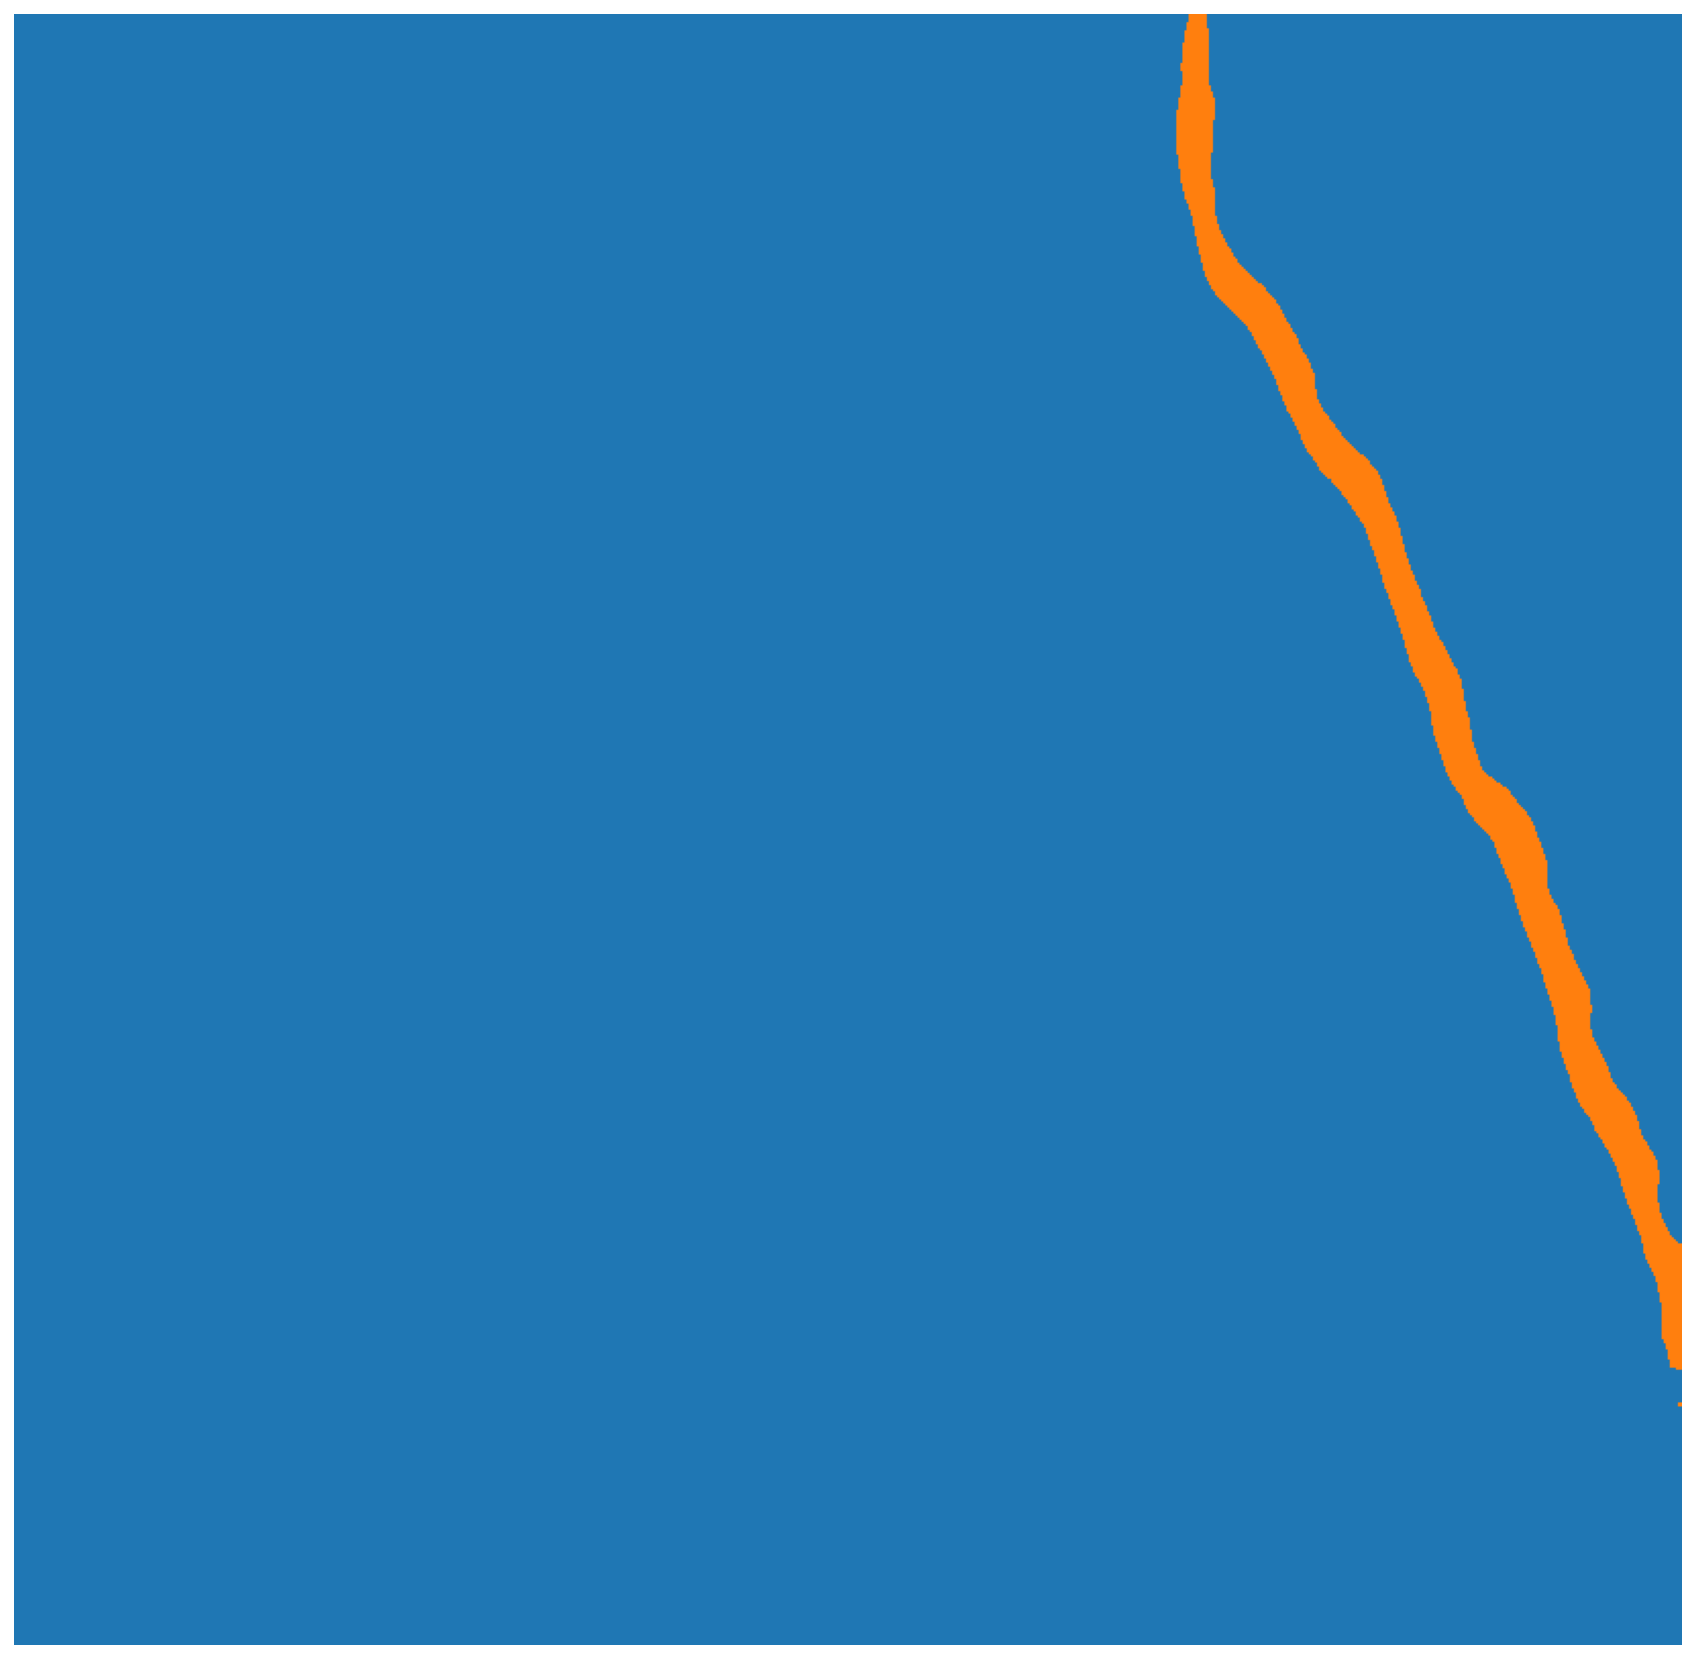

In [71]:
import itertools
import seaborn as sns
palette = itertools.cycle(sns.color_palette())

# The segmentation is stored in a special-format png
panoptic_seg = Image.open(io.BytesIO(post_result['png_string']))
panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
# We retrieve the ids corresponding to each mask
panoptic_seg_id = rgb2id(panoptic_seg)

# Finally we color each mask individually
panoptic_seg[:, :, :] = 0
for id in range(panoptic_seg_id.max() + 1):
  panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255
plt.figure(figsize=(15,15))
plt.imshow(panoptic_seg)
plt.axis('off')
plt.show()

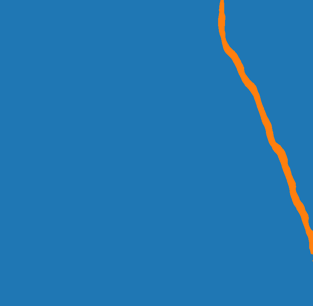

In [91]:
Image.fromarray(panoptic_seg).resize((h,w))

In [89]:
h,w = Image.open(image_path).convert('RGB').size

(313, 306)

In [22]:
from PIL import Image
import requests
import io
import math
import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

import torch
from torch import nn
from torchvision.models import resnet50
import torchvision.transforms as T
import numpy
torch.set_grad_enabled(False);

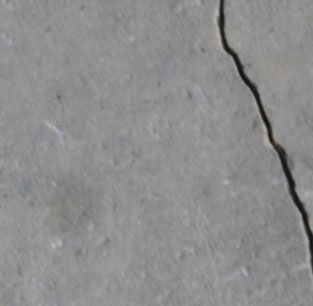

In [72]:
Image.open(image_path)

In [109]:
for im_file in files_100:

  img = Image.open(im_file).convert('RGB')
  h,w = img.size
  img_transform = transform(img).unsqueeze(0)
  out = model(img_transform)

  probas = out['pred_logits'].softmax(-1)[0, :, :-1]
  keep = probas.max(-1).values > 0.85

  post_result = postprocessor(out, torch.as_tensor(img_transform.shape[-2:]).unsqueeze(0))[0]

  # The segmentation is stored in a special-format png
  panoptic_seg = Image.open(io.BytesIO(post_result['png_string']))
  panoptic_seg = numpy.array(panoptic_seg, dtype=numpy.uint8).copy()
  # We retrieve the ids corresponding to each mask
  panoptic_seg_id = rgb2id(panoptic_seg)

  # Finally we color each mask individually
  panoptic_seg[:, :, :] = 0
  for id in range(panoptic_seg_id.max() + 1):
    panoptic_seg[panoptic_seg_id == id] = numpy.asarray(next(palette)) * 255


  image_resized = Image.fromarray(panoptic_seg).resize((h,w))
  image_resized.save("bbox_segment/" + im_file.split('/')[-1])
  

/root/.cache/torch/hub/facebookresearch_detr_main/models/position_encoding.py:41: UserWarning: __floordiv__ is deprecated, and its behavior will change in a future version of pytorch. It currently rounds toward 0 (like the 'trunc' function NOT 'floor'). This results in incorrect rounding for negative values. To keep the current behavior, use torch.div(a, b, rounding_mode='trunc'), or for actual floor division, use torch.div(a, b, rounding_mode='floor').
  dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)


In [ ]:
Image.open('/content/bbox_segment/0002.jpg').size

In [ ]:
Image.open('')

In [108]:
! rm -r /content/bbox_segment/*